In [1]:
import pandas as pd
import numpy as np
import os
import re

%matplotlib inline

In [2]:
%ls ../experiments/

exp0/  exp1/  exp2/


In [3]:
%%bash
head ../experiments/exp0/2enc.1dec.0.2dropout.100epochs.log

Logging to ./experiments/2enc.1dec.0.2dropout.100epochs.log
Chosen device not a CPU! Setting CUDA tensors as default...
Epoch 0 done.
Train Intent loss: 5218.039520263672
Train Slot loss: 82683.29223632812
Dev Intent loss: 541.3716468811035
Dev slot loss: 12517.972534179688
Intent accuracy (dev): 0.718
Slot F1 (dev): 0.7203
Epoch 1 done.


In [4]:
foo = re.compile("Slot F1 \(dev\)")

In [5]:
def parse_log_file(fname: str, exp_num: int = 0) -> dict:
    
    RE_TRAIN_INTENT_LOSS = re.compile("Train Intent loss")
    RE_TRAIN_SLOT_LOSS = re.compile("Train Slot loss")
    RE_DEV_INTENT_LOSS = re.compile("Dev Intent loss")
    RE_DEV_SLOT_LOSS = re.compile("Dev slot loss")
    RE_DEV_INTENT_ACC = re.compile("Intent accuracy \(dev\)")
    RE_DEV_SLOT_F1 = re.compile("Slot F1 \(dev\)")
    RE_TEST_INTENT_ACC = re.compile("Intent accuracy \(test\)")
    RE_TEST_SLOT_F1 = re.compile("Slot F1 \(test\)")
    
    base_path = f"../experiments/exp{exp_num}"
    enc, dec, drop1, drop2, epochs = fname.split('.')[:-1]
    drop = ".".join((drop1, drop2))[:3]
    epochs = re.match('^\d+', epochs).group(0)
    data = {
        'n_encoder_layers': int(enc[0]),
        'n_decoder_layers': int(dec[0]),
        'p_dropout': float(drop[:3]),
        'n_epochs': int(epochs)
    }
    with open(f"{base_path}/{fname}", encoding='utf-8') as f:
        log_lines = (line.strip('\n') for line in f.readlines())
        train_intent_losses = []
        train_slot_losses = []
        dev_intent_losses = []
        dev_slot_losses = []
        dev_intent_accuracies = []
        dev_slot_f1s = []
        test_intent_loss = np.inf
        test_slot_loss = np.inf
        test_intent_accuracy = 0.0
        test_slot_f1 = 0.0
        grab_value = lambda line: float(line.split()[-1])
        for line in log_lines:
            if RE_TRAIN_INTENT_LOSS.match(line):
                train_intent_losses.append(grab_value(line))
            elif RE_TRAIN_SLOT_LOSS.match(line):
                train_slot_losses.append(grab_value(line))
            elif RE_DEV_INTENT_LOSS.match(line):
                dev_intent_losses.append(grab_value(line))
            elif RE_DEV_SLOT_LOSS.match(line):
                dev_slot_losses.append(grab_value(line))
            elif RE_DEV_INTENT_ACC.match(line):
                dev_intent_accuracies.append(grab_value(line))
            elif RE_DEV_SLOT_F1.match(line):
                dev_slot_f1s.append(grab_value(line))
            elif RE_TEST_INTENT_ACC.match(line):
                test_intent_accuracy = grab_value(line)
            elif RE_TEST_SLOT_F1.match(line):
                test_slot_f1 = grab_value(line)
        data['metrics'] = {
            'train_intent_loss': train_intent_losses,
            'train_slot_loss': train_slot_losses,
            'dev_intent_loss': dev_intent_losses,
            'dev_slot_loss': dev_slot_losses,
            'dev_intent_acc': dev_intent_accuracies,
            'dev_slot_f1': dev_slot_f1s,
            'test_intent_acc': test_intent_accuracy,
            'test_slot_f1': test_slot_f1
        }
        
    return data

In [6]:
import os

In [7]:
parse_log_file('1enc.2dec.0.4dropout.25epochs.log')

{'n_encoder_layers': 1,
 'n_decoder_layers': 2,
 'p_dropout': 0.4,
 'n_epochs': 25,
 'metrics': {'train_intent_loss': [5525.887809753418,
   4950.526916503906,
   3957.2034282684326,
   2710.919672012329,
   2333.149927139282,
   2094.7239332199097,
   1867.6439428329468,
   1612.94145154953,
   1303.1477184295654,
   1059.475350856781,
   909.7802736759186,
   752.1367783546448,
   618.2924234867096,
   474.1913400888443,
   392.5712349116802,
   337.2050779312849,
   378.2522097527981,
   271.2536050379276,
   237.68133118748665,
   233.8811457157135,
   168.58447996526957,
   145.8780529126525,
   94.46450130082667,
   73.80755047127604,
   54.21653393562883],
  'train_slot_loss': [99321.78192138672,
   47478.70520019531,
   30363.67852783203,
   20346.21775817871,
   13158.605407714844,
   8852.376556396484,
   6170.622573852539,
   4294.864526748657,
   3098.2678508758545,
   2193.4837255477905,
   1644.1403169631958,
   1266.2677006721497,
   1016.5863347053528,
   740.3233416080

## Run 0

In [8]:
exp0_filenames = os.listdir('../experiments/exp0/')

In [9]:
exp0_logs = [parse_log_file(fname, exp_num=0) for fname in exp0_filenames]

In [10]:
def plot_dev_metrics(logs):
    df = pd.DataFrame()
    for ix, log in enumerate(logs):
        dev_slot_f1 = log['metrics']['dev_slot_f1']
        dev_intent_acc = log['metrics']['dev_intent_acc']    
        df[f'dev_slot_f1_{ix}'] = dev_slot_f1
        df[f'dev_intent_acc_{ix}'] = dev_intent_acc
    df.plot(title='Dev intent accuracy', legend=None, figsize=(12, 6))

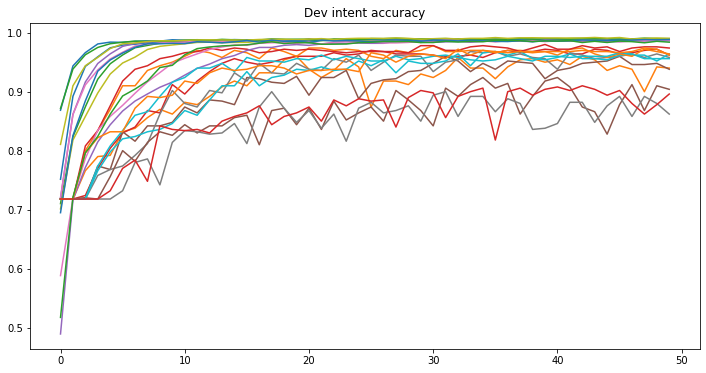

In [11]:
plot_dev_metrics([log for log in exp0_logs if log['n_epochs'] == 50])

## Plot 1: 2x2 grid, according to number of layers

In [12]:
import itertools as it

In [13]:
def flatten(nested):
    return list(it.chain.from_iterable(nested))

In [14]:
def two_by_two_grid(logs):
    layer_to_ix = {
        (1,1): 0,
        (1,2): 1,
        (2,1): 2,
        (2,2): 3
    }
    df = pd.DataFrame()
    intent_accs = []
    slot_f1s = []
    n_enc_layers = []
    n_dec_layers = []
    for log in logs:
        dev_slot_f1 = log['metrics']['dev_slot_f1']
        dev_intent_acc = log['metrics']['dev_intent_acc']
        intent_accs.extend(dev_intent_acc)
        slot_f1s.extend(dev_slot_f1)
        n_enc_layers.extend([log['n_encoder_layers'] for _ in dev_intent_acc])
        n_dec_layers.extend([log['n_decoder_layers'] for _ in dev_intent_acc])
    df['dev_slot_f1'] = slot_f1s
    df['dev_intent_acc'] = intent_accs
    df['layers'] = [(enc, dec) for enc, dec in zip(n_enc_layers, n_dec_layers)]
    return df

## Table 1: Dev acc/f1 & test acc/f1 table

In [24]:
def acc_f1_table(logs):
    n_encs = []
    n_decs = []
    dropouts = []
    dev_accs = []
    dev_f1s = []
    test_accs = []
    test_f1s = []
    for log in logs:
        n_encs.append(log['n_encoder_layers'])
        n_decs.append(log['n_decoder_layers'])
        dropouts.append(log['p_dropout'])
        dev_accs.append(np.max(log['metrics']['dev_intent_acc']))
        dev_f1s.append(np.max(log['metrics']['dev_slot_f1']))
        test_accs.append(log['metrics']['test_intent_acc'])
        test_f1s.append(log['metrics']['test_slot_f1'])
    out = pd.DataFrame({
        'Encoder layers': n_encs,
        'Decoder layers': n_decs,
        'Dropout prob.': dropouts,
        'Intent acc. (dev)': dev_accs,
        'Slot F1 (dev)': dev_f1s,
        'Intent acc. (test)': test_accs,
        'Slot F1 (test)': test_f1s
    })
    return out.set_index(['Encoder layers', \
                          'Decoder layers', 
                          'Dropout prob.'])\
              .sort_index()\
              .round(3)\
              .applymap(lambda x: 100*x)

In [25]:
acc_table = acc_f1_table([log for log in exp0_logs if log['n_epochs'] == 100])

In [26]:
acc_table

Intent acc. (dev)  Slot F1 (dev)  \
Encoder layers Decoder layers Dropout prob.                                     
1              1              0.2                         98.0           99.1   
                              0.4                         97.6           99.2   
                              0.6                         98.4           99.2   
               2              0.2                         98.2           99.0   
                              0.4                         97.8           99.1   
                              0.6                         96.2           99.0   
2              1              0.2                         97.4           99.2   
                              0.4                         97.0           99.1   
                              0.6                         97.4           99.0   
               2              0.2                         95.8           98.7   
                              0.4                         95.2           98.9   
                              0.6                         91.4           99.0   

                                             Intent acc. (test)  \
Encoder layers Decoder layers Dropout prob.                       
1              1              0.2                          96.5   
                              0.4                          96.1   
                              0.6                          97.3   
               2              0.2                          97.1   
                              0.4                          96.6   
                              0.6                          94.2   
2              1              0.2                          95.1   
                              0.4                          93.7   
                              0.6                          95.9   
               2              0.2                          89.2   
                              0.4                          88.1   
                              0.6                          84.6   

                                             Slot F1 (test)  
Encoder layers Decoder layers Dropout prob.                  
1              1              0.2                      97.4  
                              0.4                      97.7  
                              0.6                      97.8  
               2              0.2                      97.3  
                              0.4                      97.4  
                              0.6                      97.5  
2              1              0.2                      97.6  
                              0.4                      97.5  
                              0.6                      97.6  
               2              0.2                      97.1  
                              0.4                      97.3  
                              0.6                      97.5

In [29]:
exp0_filenames = os.listdir('../experiments/exp0')
exp1_filenames = os.listdir('../experiments/exp1')
exp2_filenames = os.listdir('../experiments/exp2')

In [34]:
exp0_logs = [parse_log_file(log, exp_num=0) for log in exp0_filenames]
exp1_logs = [parse_log_file(log, exp_num=1) for log in exp1_filenames]
exp2_logs = [parse_log_file(log, exp_num=2) for log in exp2_filenames]

In [35]:
exp0_logs100 = [log for log in exp0_logs if log['n_epochs'] == 100]
exp1_logs100 = [log for log in exp1_logs if log['n_epochs'] == 100]
exp2_logs100 = [log for log in exp2_logs if log['n_epochs'] == 100]

In [76]:
def mean_sd_table(nested_logs):
    tables = [acc_f1_table(logs) for logs in nested_logs]
    mean_table = sum(tables)/3.0
    sd_table = sum((t - mean_table)**2 for t in tables).applymap(np.sqrt)
    return mean_table.round(1), sd_table.round(1)

In [77]:
mean_table, sd_table = mean_sd_table([exp0_logs100, exp1_logs100, exp2_logs100])

In [78]:
def concat_tables(mean_table, sd_table):
    out = pd.DataFrame(index=mean_table.index, 
                       columns=mean_table.columns)
    for row_ix in mean_table.index:
        for col_ix in mean_table.columns:
            mean = mean_table.loc[row_ix][col_ix]
            sd = sd_table.loc[row_ix][col_ix]
            out.loc[row_ix][col_ix] = f"{mean} +/- {sd}"
    return out

In [79]:
def aggregate_stats_table(nested_logs):
    mean_table, sd_table = mean_sd_table(nested_logs)
    aggregate_table = concat_tables(mean_table, sd_table)
    return aggregate_table

In [90]:
aggregate_stats_table([exp0_logs100, 
                             exp1_logs100, 
                             exp2_logs100])

Intent acc. (dev) Slot F1 (dev)  \
Encoder layers Decoder layers Dropout prob.                                   
1              1              0.2                98.2 +/- 0.3  99.1 +/- 0.1   
                              0.4                97.9 +/- 0.4  99.2 +/- 0.1   
                              0.6                98.2 +/- 0.5  99.2 +/- 0.1   
               2              0.2                98.0 +/- 0.5  99.0 +/- 0.1   
                              0.4                97.7 +/- 0.2  99.0 +/- 0.2   
                              0.6                96.9 +/- 1.0  99.1 +/- 0.1   
2              1              0.2                97.4 +/- 0.3  99.1 +/- 0.2   
                              0.4                97.2 +/- 0.3  99.1 +/- 0.0   
                              0.6                97.7 +/- 0.3  99.0 +/- 0.1   
               2              0.2                94.5 +/- 2.6  98.8 +/- 0.2   
                              0.4                95.8 +/- 0.8  98.8 +/- 0.2   
                              0.6                92.5 +/- 4.3  99.0 +/- 0.1   

                                            Intent acc. (test) Slot F1 (test)  
Encoder layers Decoder layers Dropout prob.                                    
1              1              0.2                 96.7 +/- 0.3   97.5 +/- 0.2  
                              0.4                 96.6 +/- 0.9   97.7 +/- 0.1  
                              0.6                 96.8 +/- 0.7   97.8 +/- 0.1  
               2              0.2                 96.6 +/- 0.7   97.4 +/- 0.3  
                              0.4                 96.0 +/- 1.2   97.6 +/- 0.3  
                              0.6                 95.6 +/- 1.8   97.6 +/- 0.1  
2              1              0.2                 94.8 +/- 0.4   97.4 +/- 0.3  
                              0.4                 94.2 +/- 1.5   97.6 +/- 0.2  
                              0.6                 94.5 +/- 1.9   97.6 +/- 0.1  
               2              0.2                 88.7 +/- 1.6   97.1 +/- 0.0  
                              0.4                 89.7 +/- 2.9   97.2 +/- 0.1  
                              0.6                 86.1 +/- 3.3   97.4 +/- 0.2